## Introduction

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from utils import adf_test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.api import OLS


# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

## Data
<div style="width:800px; text-align:left; margin-left:0;">
Given csv file with prices series for 10 different assets we need to find cointegrated pairs and choose one for the further analysis. We begin our analysis with visual inspection of the series.

Recall that two series are cointegrated if both of them are $I(n)$, so integrated of order $n$, but some linear relationship of those series is $I(n-1)$, for $n \geq 1$. 

With financial series we most often deal with series $I(1)$ and $I(0)$, so we expect to find 2 nonstationary series whose linear combination is stationary. Visually we expect that the difference between those series is fluctuating around some mean value with time. This is because:
$$
Y_t - \beta X_t = Z_t
$$
where $X_t$ and $Y_t$ are cointegrated series and $Z_t$ is stationary. As $Z_t$ is stationary, thus has constant mean over time, we should expect difference between $Y_t$ and $X_t$ fluctuating around some mean value.
</div>

In [ ]:
# Loading the data
df = pd.read_csv('data/prices.csv')

In [ ]:
df.head()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
0,2023-09-09,109.41,109.41,109.41,124.24,124.47,109.41,119.94,104.66,107.62,119.32
1,2023-09-10,109.41,109.41,109.41,124.21,124.32,109.41,101.39,104.34,102.61,119.36
2,2023-09-11,109.42,109.41,109.41,124.41,124.37,109.41,97.64,104.23,99.16,119.38
3,2023-09-12,108.68,110.19,111.12,123.93,124.82,109.41,94.35,107.23,103.39,121.06
4,2023-09-13,106.21,110.88,112.92,122.68,123.91,107.84,96.22,109.71,102.43,122.17


In [ ]:
df.tail()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
595,2025-04-26,236.25,157.43,98.53,187.42,104.92,70.59,38.88,86.80,136.49,215.32
596,2025-04-27,235.26,159.66,100.24,187.09,104.51,69.54,30.55,89.88,131.38,220.03
597,2025-04-28,235.07,162.04,102.27,187.40,104.03,68.72,38.72,93.09,129.86,224.60
598,2025-04-29,234.99,164.39,103.17,186.88,103.34,67.41,44.01,94.24,128.16,229.31
599,2025-04-30,234.70,167.05,105.45,186.76,102.90,66.36,53.75,98.26,132.49,234.87


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    600 non-null    object 
 1   y1      600 non-null    float64
 2   y2      600 non-null    float64
 3   y3      600 non-null    float64
 4   y4      600 non-null    float64
 5   y5      600 non-null    float64
 6   y6      600 non-null    float64
 7   y7      600 non-null    float64
 8   y8      600 non-null    float64
 9   y9      600 non-null    float64
 10  y10     600 non-null    float64
dtypes: float64(10), object(1)
memory usage: 51.7+ KB


We can see above that the date column in our data is of object type representing string. It is recommended to work with dates as datetime objects set as index of the dateframe. So we change type of the data contained in date column to datetime and set the column as index.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    600 non-null    datetime64[ns]
 1   y1      600 non-null    float64       
 2   y2      600 non-null    float64       
 3   y3      600 non-null    float64       
 4   y4      600 non-null    float64       
 5   y5      600 non-null    float64       
 6   y6      600 non-null    float64       
 7   y7      600 non-null    float64       
 8   y8      600 non-null    float64       
 9   y9      600 non-null    float64       
 10  y10     600 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 51.7 KB


In [ ]:
df.set_index('date', inplace = True)
df.head()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
date,,,,,,,,,,
2023-09-09,109.41,109.41,109.41,124.24,124.47,109.41,119.94,104.66,107.62,119.32
2023-09-10,109.41,109.41,109.41,124.21,124.32,109.41,101.39,104.34,102.61,119.36
2023-09-11,109.42,109.41,109.41,124.41,124.37,109.41,97.64,104.23,99.16,119.38
2023-09-12,108.68,110.19,111.12,123.93,124.82,109.41,94.35,107.23,103.39,121.06
2023-09-13,106.21,110.88,112.92,122.68,123.91,107.84,96.22,109.71,102.43,122.17


In [ ]:
# Split data
sample_df = df.iloc[:575]
sample_df.tail()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
date,,,,,,,,,,
2025-04-01,224.12,166.00,82.20,181.88,112.36,85.41,67.08,60.90,161.17,232.59
2025-04-02,222.07,165.75,82.16,180.99,112.84,86.48,63.81,61.00,164.55,232.09
2025-04-03,219.19,164.16,81.66,179.85,113.13,87.45,61.44,60.19,166.98,228.88
2025-04-04,215.87,163.47,82.28,177.80,112.74,85.95,64.40,60.62,165.29,227.57
2025-04-05,213.66,162.05,82.90,176.79,112.85,85.84,68.93,61.68,164.04,224.79


Now we can move on to the visual inspection. As we shown above we should expect difference between cointegrated series to fluctuate around some mean value. Starting from the top the behavior is clear for orange and ligth blue lines, so for y2 and y10 series.

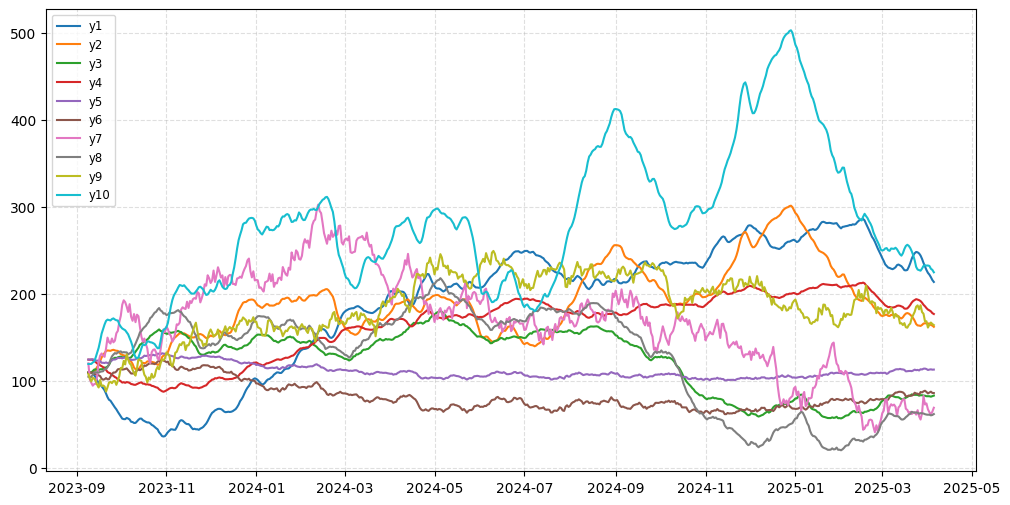

In [ ]:
# Visual inspection
plt.figure(figsize=(12, 6))
plt.plot(sample_df, label = sample_df.columns.values)
plt.grid(linestyle = '--', alpha = 0.4)
plt.legend(loc = 'upper left', fontsize = 'small')
plt.show()

In [ ]:
coint_df = sample_df[['y2', 'y10']]
coint_df.head()

,y2,y10
date,,
2023-09-09,109.41,119.32
2023-09-10,109.41,119.36
2023-09-11,109.41,119.38
2023-09-12,110.19,121.06
2023-09-13,110.88,122.17


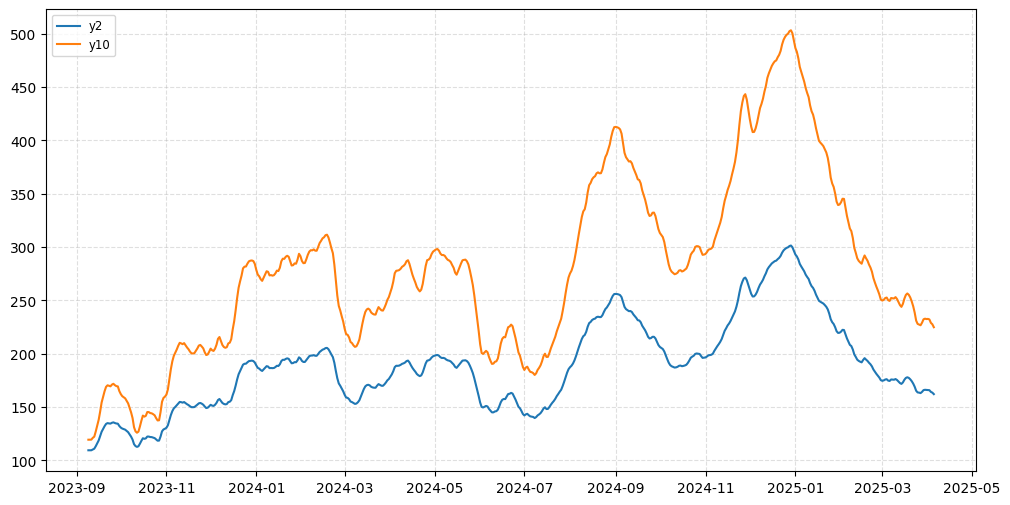

In [ ]:
# Visual inspection
plt.figure(figsize=(12, 6))
plt.plot(coint_df, label = coint_df.columns.values)
plt.grid(linestyle = '--', alpha = 0.4)
plt.legend(loc = 'upper left', fontsize = 'small')
plt.show()

## Stationatity

Stationarity is an important concept in time series analysis. Weak stationarity assumes constant mean, variance and autocovariance over time. For our case statoinarity needs to be assesed for cointegration testing (check whether both series are $I(1)$) and to determine d order of ARIMA.

#### Testing for stationarity

Common way to check stationarity is visual analysis followed by statistical test like ADF test. We would expect stationary series to fluctuate over constant mean with irregular deviations of similar size. For both of our series we can clearly see some periods with upward trend and some with downward trend which implies no constant mean over time and non-stationarity of the series. 

We can investigate this further with Augmented Dickey-Fuller test for unit root. ADF test statistic is derived assuming unit root existance (there exists root of the characteristic equation equal 1) implying non-stationarity. Test statistic does not follow any standard probability distribution and critical values were explicitly derived by Dickey and Fuller what is known as Dickey-Fuller table. For the statistical inference to be meaningful we need to make sure that the error term of model constructed for the test does not exhibit autocorrelation. For this purpose we simultaneously perform Breush-Godfrey tests for autocorrelation for some predetermined numbers of augmentations.



In [ ]:
adf_test(coint_df['y2'], max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,0.556701,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
1,1,-0.347718,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
2,2,-0.143603,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
3,3,-0.310606,-2.567,-1.941,-1.616,0.0000,0.0000,0.0001
4,4,-0.204139,-2.567,-1.941,-1.616,0.0000,0.0003,0.0020
5,5,-0.342668,-2.567,-1.941,-1.616,0.0034,0.0192,0.1079
6,6,-0.264692,-2.567,-1.941,-1.616,0.2066,0.2920,0.5907
7,7,-0.324053,-2.567,-1.941,-1.616,0.1211,0.3662,0.6637
8,8,-0.340286,-2.567,-1.941,-1.616,0.5275,0.2668,0.5263
9,9,-0.390800,-2.567,-1.941,-1.616,0.1279,0.4331,0.5895


In [ ]:
adf_test(coint_df['y10'], max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,0.403068,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
1,1,-0.535834,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
2,2,-0.305938,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
3,3,-0.477855,-2.567,-1.941,-1.616,0.0000,0.0000,0.0004
4,4,-0.365681,-2.567,-1.941,-1.616,0.0003,0.0011,0.0038
5,5,-0.499809,-2.567,-1.941,-1.616,0.0148,0.0475,0.1557
6,6,-0.417418,-2.567,-1.941,-1.616,0.3098,0.2768,0.4888
7,7,-0.466908,-2.567,-1.941,-1.616,0.1512,0.2835,0.4763
8,8,-0.479136,-2.567,-1.941,-1.616,0.3900,0.1911,0.3227
9,9,-0.529098,-2.567,-1.941,-1.616,0.1057,0.4195,0.3862


Results of ADF testing procedure for both series are shown above. In both cases null hypothesis is strongly rejected, and 6 augmentations is enough to get rid of residuals autocorrelation. We therefore conclude that both series are non-stationary.

In [ ]:
coint_df['dy2'] = coint_df['y2'].diff()
coint_df['dy10'] = coint_df['y10'].diff()

In [ ]:
coint_df.dropna(inplace = True)

In [ ]:
adf_test(coint_df['dy2'], max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-6.528163,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
1,1,-8.511276,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
2,2,-6.457474,-2.567,-1.941,-1.616,0.0000,0.0000,0.0004
3,3,-7.252590,-2.567,-1.941,-1.616,0.0005,0.0013,0.0084
4,4,-6.058939,-2.567,-1.941,-1.616,0.0193,0.0753,0.2803
5,5,-6.579766,-2.567,-1.941,-1.616,0.6948,0.6619,0.8792
6,6,-5.995355,-2.567,-1.941,-1.616,0.4666,0.7827,0.9356
7,7,-5.979757,-2.567,-1.941,-1.616,0.9990,0.6538,0.8591
8,8,-5.525512,-2.567,-1.941,-1.616,0.5367,0.8667,0.9232
9,9,-5.068083,-2.567,-1.941,-1.616,0.7879,0.9461,0.9786


In [ ]:
adf_test(coint_df['dy10'], max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-6.551536,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
1,1,-8.469534,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
2,2,-6.520269,-2.567,-1.941,-1.616,0.0001,0.0002,0.0021
3,3,-7.201578,-2.567,-1.941,-1.616,0.0020,0.0064,0.0148
4,4,-6.109034,-2.567,-1.941,-1.616,0.0703,0.1498,0.3498
5,5,-6.515978,-2.567,-1.941,-1.616,0.8261,0.6149,0.7834
6,6,-6.078592,-2.567,-1.941,-1.616,0.5026,0.6545,0.7948
7,7,-5.943100,-2.567,-1.941,-1.616,0.9069,0.5051,0.6387
8,8,-5.579598,-2.567,-1.941,-1.616,0.4123,0.8208,0.7457
9,9,-5.020012,-2.567,-1.941,-1.616,0.6084,0.8051,0.9448


However unit root tests have significant drawdown. Unit root specifically determines lack of mean reverting behavior of analyzed series. But constant mean is only 1 out of 3 conditions for weak stationarity. Financial time series often even after differencing exibits non-stationarity even if according to unit root test we would reject null hypothesis and assume stationarity. Take for example stock prices. Nominal changes in prices are proportional to the price, meaning that when stock price increases nominal changes increases as well implying non-constant variance. Therefore it may be better to first take logarithmic transformation of analyzed financial series. Then first differences of such series would be logarithmic returns, that usually can be treated approximately as percentage returns. 

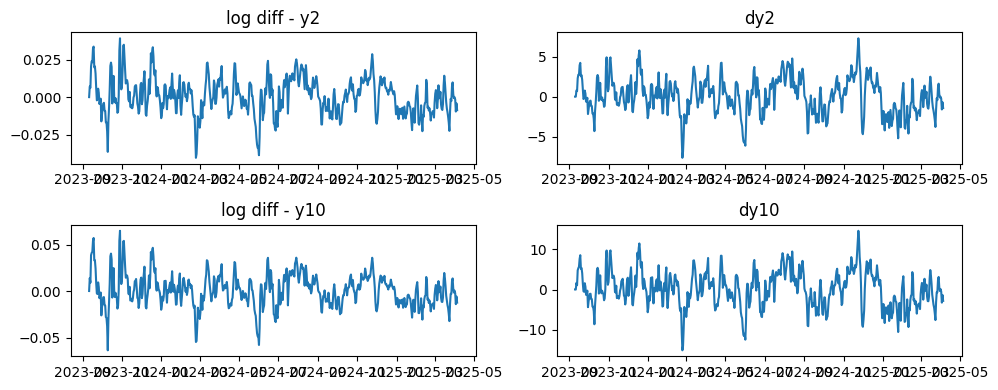

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (10, 4))

axs[0, 0].plot(np.log(coint_df['y2']).diff().dropna())
axs[0, 0].set_title('log diff - y2')

axs[0, 1].plot(coint_df['dy2'])
axs[0, 1].set_title('dy2')

axs[1, 0].plot(np.log(coint_df['y10']).diff().dropna())
axs[1, 0].set_title('log diff - y10')

axs[1, 1].plot(coint_df['dy10'])
axs[1, 1].set_title('dy10')

plt.tight_layout()

No significant difference between differenced series and differenced logarithm of the series is visible on the plots shown above. Therefore for simplicity we continue without logarithmic transformation.

## ARIMA

We will apply Box-Jenkins procedure to find p,d,q values for ARIMA(p, d, q). This procedure utilizes ACF and PACF to determine correspondingly right MA order and right AR model. We already have order of integration as we have shown that series are both non-stationary but their differences are stationary implying integration of order 1 - $I(1)$

Let's start with procedure for y2 series. We shown that it is $I(1)$ so we plot ACF and PACF for differenced series.

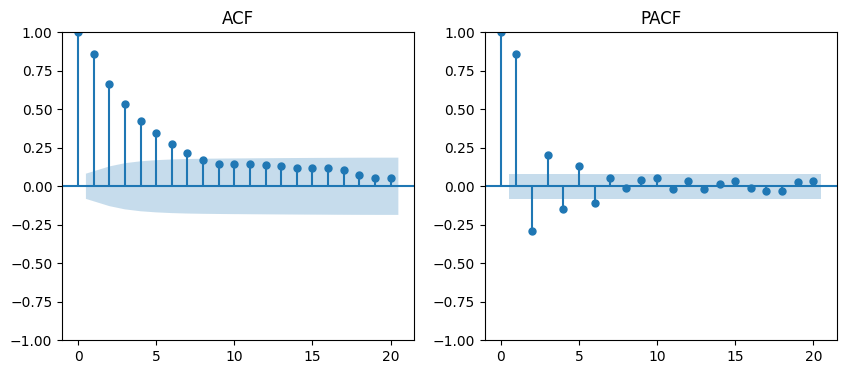

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(coint_df['dy2'], lags=20, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(coint_df['dy2'], lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

We observe quite interesting behavior - ACF is decaying exponentially, which would be expected for simple AR(1) models. PACF on the other hand oscilates around 0, but also the greatest spike, which at the same time is significantly greater than other spikes is the first one (at lag 1). There is a possibility that the right model will be just AR(1) for differenced series, so ARIMA(1,1,0). Let's try this model

In [ ]:
model = ARIMA(coint_df['y2'].values, order = (1,1,0))
arima_110 = model.fit()
print(arima_110.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -883.275
Date:                Fri, 16 May 2025   AIC                           1770.550
Time:                        19:02:01   BIC                           1779.251
Sample:                             0   HQIC                          1773.944
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8595      0.020     42.860      0.000       0.820       0.899
sigma2         1.2748      0.073     17.383      0.000       1.131       1.418
Ljung-Box (L1) (Q):                  37.04   Jarque-

In [ ]:
ljung_test = acorr_ljungbox(arima_110.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   0.214954   0.998944
10  0.409878   0.999997
15  0.519203   1.000000
20  0.774348   1.000000
25  0.813136   1.000000


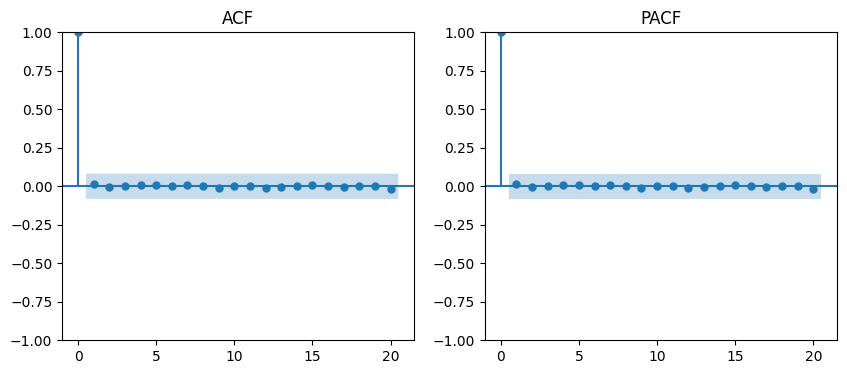

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_110.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_110.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

Model specification is correct. There is no autocorrelations in model residuals, and as usually we prefer simple models we could just take this one and move forward with the analysis as this model is basically the simplest one we can get. However, we can't really say that this model is certainly the best one without some comparison. It is therefore useful to study also different model specification and compare them on information criteria basis (lower is better).

---

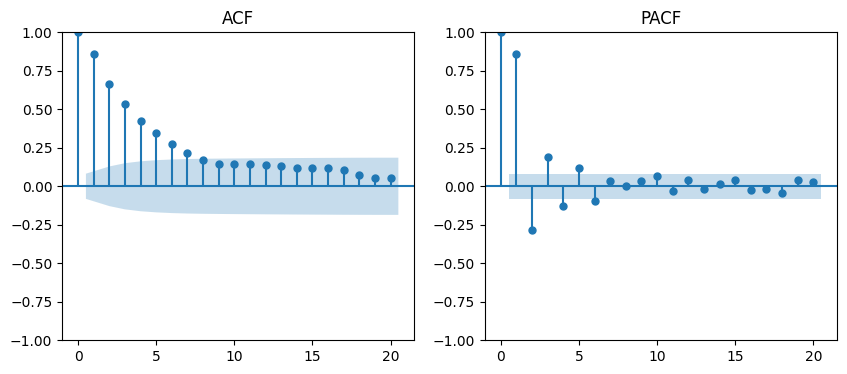

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(coint_df['dy10'], lags=20, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(coint_df['dy10'], lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

In [ ]:
model = ARIMA(coint_df['y2'].values, order = (1,1,0))
arima_110_2 = model.fit()
print(arima_110_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -883.275
Date:                Fri, 16 May 2025   AIC                           1770.550
Time:                        19:25:26   BIC                           1779.251
Sample:                             0   HQIC                          1773.944
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8595      0.020     42.860      0.000       0.820       0.899
sigma2         1.2748      0.073     17.383      0.000       1.131       1.418
Ljung-Box (L1) (Q):                  37.04   Jarque-

---

In [ ]:
# coint model

model_coint = OLS(coint_df['y2'], coint_df['y10']).fit()
print(model_coint.summary())

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.035e+05
Date:                Fri, 16 May 2025   Prob (F-statistic):                        0.00
Time:                        19:38:45   Log-Likelihood:                         -2345.6
No. Observations:                 574   AIC:                                      4693.
Df Residuals:                     573   BIC:                                      4698.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

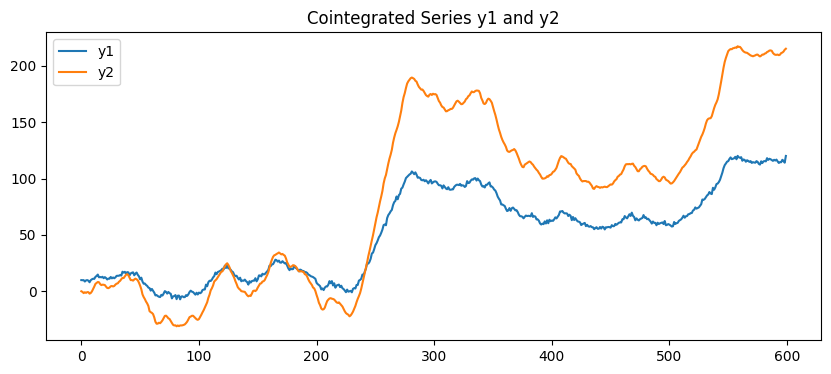

In [ ]:
n = 600
alpha = 0.85
c = 10

# Generate a stationary error correction term (cointegration residual)
z = np.random.normal(0, 1, size=n)

# Initialize y2 as a random walk with AR(1) dynamics in differences
dy2 = np.zeros(n)
for t in range(1, n):
    dy2[t] = alpha * dy2[t - 1] + np.random.normal(0, 1)
y2 = np.cumsum(dy2)

# Construct y1 such that: y1 = -0.5*y2 + z  =>  y1 + 0.5*y2 = z (stationary)
y1 = c + 0.5 * y2 + z

# Combine into a DataFrame
df = pd.DataFrame({'y1': y1, 'y2': y2})
df.plot(title='Cointegrated Series y1 and y2', figsize=(10, 4))
plt.show()